# Density-based spatial clustering of applications with noise (DBSCAN)

---

DBSCAN is a clustering algorithm that groups datapoints together based on "density". Nearby points get assigned to a common cluster, and outlier points get assigned to their own clusters. DBSCAN is effective and attractive for its simplicity and minimal pre-specified parameters.

There are only two parameters that need to be specified for DBSCAN:

    eps : a minimum distance between points that can define a "connection"
    
    min_samples : minimum number of points that a point needs to have 
                  as neighbors to define it as a "core sample"
    
**Core samples** are by design the points that lie internally within a cluster. 

**Non-core samples** do not meet the minimum required neighboring points, but are still connected to a cluster defined by a core sample or samples. Hence these points lie on the edges of a cluster.

**Outliers** are points that do not meet the distance criteria to a cluster nor minimum neighbors to form a new cluster.


---

## DBSCAN algorithm

The DBSCAN algorithm proceeds iteratively through the points, determining via the distance measure and minimum samples specified whether points are core samples, edge samples, or outliers.

Here is the pseudocode algorithm below, which we will be coding up ourselves:


```
DBSCAN(D, eps, MinPts) {
   C = 0
   for each point P in dataset D {
      if P is visited
         continue next point
      mark P as visited
      NeighborPts = regionQuery(P, eps)
      if sizeof(NeighborPts) < MinPts
         mark P as NOISE
      else {
         C = next cluster
         expandCluster(P, NeighborPts, C, eps, MinPts)
      }
   }
}

expandCluster(P, NeighborPts, C, eps, MinPts) {
   add P to cluster C
   for each point P' in NeighborPts { 
      if P' is not visited {
         mark P' as visited
         NeighborPts' = regionQuery(P', eps)
         if sizeof(NeighborPts') >= MinPts
            NeighborPts = NeighborPts joined with NeighborPts'
      }
      if P' is not yet member of any cluster
         add P' to cluster C
   }
}

regionQuery(P, eps)
   return all points within P's eps-neighborhood (including P)
```

---

## DBSCAN in parts

We can roll our own DBSCAN following the pseudcode above. Doing it piece by piece in parts will make it clear how the algorithm works.

### 1. Create some clustered data

sklearn has some nice data generation functions in its `sklearn.datasets` module. I've loaded a handful of them below. You can use them to create clustered data easily to test clustering algorithms.

Generate clustered data and plot it out.

In [85]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

plt.style.use('fivethirtyeight')

from ipywidgets import *
from IPython.display import display

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [86]:
# Dataset generators:
from sklearn.datasets import make_biclusters, make_blobs, make_circles, make_moons

In [91]:
X, bloby = make_blobs(n_samples=200, n_features=2,centers= 4, cluster_std=1.5)

In [92]:
def plot_clusters(X):
    fig, ax = plt.subplots(figsize = (6,6))
    ax.scatter(X[:,0],X[:,1])
    plt.show()

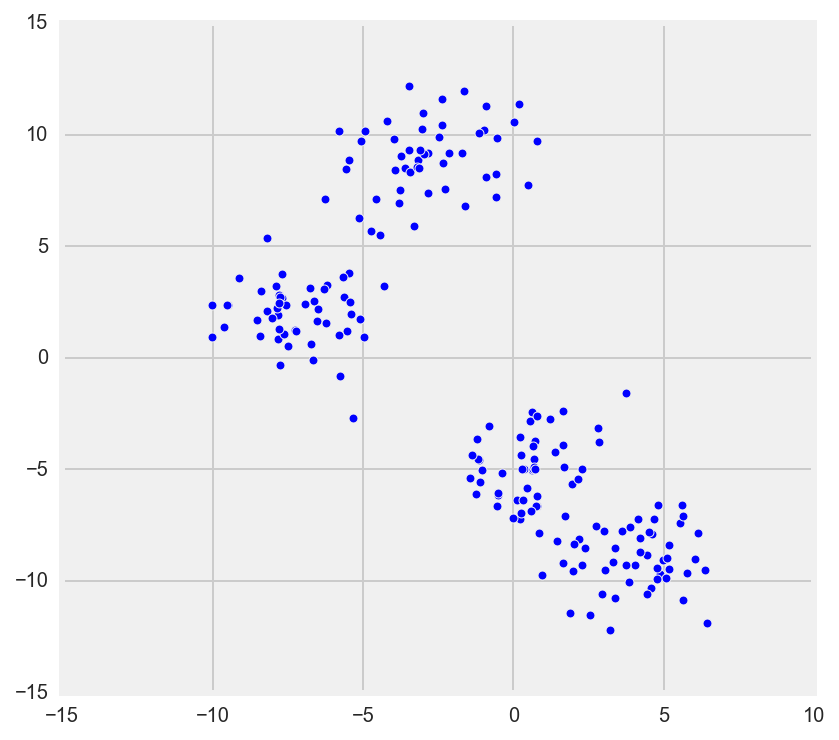

In [93]:
plot_clusters(X)

---

### 2. Make the skeleton of the DBSCAN class

Start laying out the blueprint for how DBSCAN will work. We'll need to start out:

1. An `__init__` function to initialize the class with the `eps` and `min_samples` arguments.
- A (for now empty) `fit` function that will run DBSCAN on the data.

In [94]:
from sklearn.metrics.pairwise import euclidean_distances

In [95]:
tmp = X[0:3,:]
tmp

array([[ -2.84126797,   7.38765141],
       [  6.15845314,  -7.83478403],
       [  0.03724537,  10.56895484]])

In [62]:
euclidean_distances(tmp)

array([[  0.        ,  14.11984802,  13.13324667],
       [ 14.11984802,   0.        ,   1.08398423],
       [ 13.13324667,   1.08398423,   0.        ]])

In [63]:
class DBSCANKK():
    def __init__(self,eps=0.5, min_samples=4):
        self.eps = eps
        self.min_samples = min_samples
        self.current_cluster = 0
        
    def region_query(self,i):
        pass
    
    def expand_cluster(self,i,neighbors):
        pass
        
    def fit(self,data):
        rows = data.shape[0]
        self.cluster_labels = np.zeros(rows)
        self.visited_points = np.zeros(rows)
        self.distances = euclidean_distances(data)
        
        for i in range(rows):
            if self.visited_points[i]==1:
                continue
            neighbors = self.region_query(i)
            if len(neighbors) < self.min_samples:
                self.cluster_labels[i] = -1
            else:
                self.current_cluster +=1
                self.expand_cluster(i,neighbors)
        pass

---

### 3. Writing the `fit` function (equivalent to the `DBSCAN` function in pseudocode)

Our `fit` function will follow the logic of the `DBSCAN` function in the pseudocode above (re-pasted here). In general, when building classes, think about what variables are best suited to be class attributes. It takes practice to get a feel for it.

```
DBSCAN(D, eps, MinPts) {
   C = 0
   for each point P in dataset D {
      if P is visited
         continue next point
      mark P as visited
      NeighborPts = regionQuery(P, eps)
      if sizeof(NeighborPts) < MinPts
         mark P as NOISE
      else {
         C = next cluster
         expandCluster(P, NeighborPts, C, eps, MinPts)
      }
   }
}
```

---

### 4. Write the function to find neighbors

We need to convert this function in the pseudocode to a class function:

```
regionQuery(P, eps)
   return all points within P's eps-neighborhood (including P)
```

I've already named this `self.find_region_points(i)` so far, so we'll call it that.

In [64]:
class DBSCANKK():
    def __init__(self,eps=0.5, min_samples=4):
        self.eps = eps
        self.min_samples = min_samples
        self.current_cluster = 0
        
    def region_query(self,i):
        distvec = self.distances[i]
        return [n for n, dist in enumerate(distvec) if dist <= self.eps]
    
    def expand_cluster(self,i,neighbors):
        
        self.cluster_labels[i] = self.current_cluster
        while len(neighbors) > 0:
            # get neighbor at the back of list:
            n = neighbors.pop()
            
            #if it hasnt been visited
            if self.visited_points[n] == 0:
                self.visited_points[n] = 1
                neighbors_neighbors = self.region_query(n)
                
                if len(neighbors_neighbors) >= self.min_samples:
                    neighbors.extend(neighbor_neighbors)
            if self.cluster_labels[n] == 0:
                self.cluster_labels[n] == self.current_cluster

        
    def fit(self,data):
        rows = data.shape[0]
        self.cluster_labels = np.zeros(rows)
        self.visited_points = np.zeros(rows)
        self.distances = euclidean_distances(data)
        
        for i in range(rows):
            if self.visited_points[i]==1:
                continue
            neighbors = self.region_query(i)
            if len(neighbors) < self.min_samples:
                self.cluster_labels[i] = -1
            else:
                self.current_cluster +=1
                self.expand_cluster(i,neighbors)


---

### 5. Write the function to expand the clusters.

The final function (and the one that actually assigns our clusters) is defined by the pseudocode as:

```
expandCluster(P, NeighborPts, C, eps, MinPts) {
   add P to cluster C
   for each point P' in NeighborPts { 
      if P' is not visited {
         mark P' as visited
         NeighborPts' = regionQuery(P', eps)
         if sizeof(NeighborPts') >= MinPts
            NeighborPts = NeighborPts joined with NeighborPts'
      }
      if P' is not yet member of any cluster
         add P' to cluster C
   }
}
```

Essentially the function takes a point id, the neighboring point ids, the cluster number, minimum distance, and minimum points, and figures out based on those components what cluster a point should be in. 

I've already pre-named this function in the `fit` function to be `expand_cluster(i, neighbors)`. We only need to pass in the current point and neighboring points because we're storing all of the other information the function needs as class attributes.

In [146]:
class DBSCANKK():
    def __init__(self,eps=0.5, min_samples=4):
        self.eps = eps
        self.min_samples = min_samples
        self.current_cluster = 0
        
        
    def region_query(self,i):
        distvec = self.distances[i]
        return [n for n, dist in enumerate(distvec) if (dist <= self.eps) and (n!=i)]
    
    def expand_cluster(self,i,neighbors):
        
        self.cluster_labels[i] = self.current_cluster
        while len(neighbors) > 0:
            # get neighbor at the back of list:
            n = neighbors.pop()
            
            #if it hasnt been visited
            if self.visited_points[n] == 0:
                self.visited_points[n] = 1
                neighbor_neighbors = self.region_query(n)
                
                if len(neighbor_neighbors) >= self.min_samples:
                    neighbors.extend(neighbor_neighbors)
            if self.cluster_labels[n] == 0:
                self.cluster_labels[n] = self.current_cluster

        
    def fit(self,data):
        rows = data.shape[0]
        self.cluster_labels = np.zeros(rows)
        self.visited_points = np.zeros(rows)
        self.distances = euclidean_distances(data)
        
        for i in range(rows):
            if self.visited_points[i]==1:
                continue
            neighbors = self.region_query(i)
            if len(neighbors) < self.min_samples:
                self.cluster_labels[i] = -1
            else:
                self.current_cluster +=1
                self.expand_cluster(i,neighbors)



In [147]:
db = DBSCANKK (eps=.5)
db.fit(X)
print db.cluster_labels

[-1. -1. -1.  1. -1. -1.  2. -1. -1. -1. -1. -1. -1.  3. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1.  1.  3. -1. -1. -1. -1. -1. -1. -1.  1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1.  1. -1. -1. -1. -1.  4. -1.  3.  4. -1. -1. -1. -1. -1.
 -1.  1. -1. -1.  5. -1. -1. -1. -1. -1. -1.  3.  5.  5. -1.  5.  3.  2.
 -1. -1.  1. -1.  5. -1. -1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1.  2. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  4. -1. -1. -1.  4.
 -1.  1. -1. -1. -1. -1. -1. -1. -1. -1.  5. -1. -1. -1.  5. -1. -1. -1.
 -1. -1.  4.  2. -1. -1. -1. -1.  2. -1. -1. -1. -1.  4. -1. -1.  2. -1.
 -1. -1.  2. -1. -1. -1. -1. -1.  3. -1. -1.  3. -1. -1. -1.  1. -1. -1.
 -1. -1. -1.  1. -1. -1. -1.  3. -1. -1. -1. -1. -1. -1. -1.  6. -1.  6.
 -1. -1.]


In [148]:
def plot_db_clusters(X,labels):
    fig, ax = plt.subplots(figsize=(6,6))
    unique_labels = np.unique(labels)
    colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
    
    for k, c in zip(unique_labels, colors):
        if k == -1:
            c = 'grey'

        class_member_mask = (labels == k)

        xy = X[class_member_mask]
        ax.scatter(xy[:, 0], xy[:, 1], color=c, s=70, label='class '+str(k))
    
    ax.legend(loc='lower right')
    plt.show()

[-1. -1. -1.  1. -1.  2.  3.  4.  4.  4.  5. -1.  4.  5.  4.  4.  2.  4.
  3.  2.  4.  2.  1. -1.  2.  1.  5.  2. -1.  4. -1. -1. -1. -1.  1. -1.
 -1.  6. -1.  2. -1.  4.  4.  2. -1.  3. -1. -1. -1.  3.  3.  2. -1.  2.
  4.  2.  5. -1.  1. -1. -1. -1. -1.  4.  4.  5.  4.  4.  5.  3. -1.  2.
  3.  1.  2. -1.  2. -1.  6.  2.  4. -1.  2.  5.  2.  2.  5.  2.  5.  3.
  5. -1.  1. -1.  2.  1. -1.  1. -1.  4. -1. -1.  7. -1. -1.  2.  2. -1.
 -1.  3. -1. -1. -1. -1. -1. -1.  1. -1. -1.  4.  1.  4.  4. -1. -1.  4.
 -1.  1. -1. -1. -1. -1.  1.  4. -1. -1.  2.  4.  2. -1.  2.  7. -1.  4.
  4. -1.  4.  3. -1. -1. -1.  6.  3. -1.  1.  2. -1.  4. -1.  2.  3.  7.
 -1. -1.  3.  3. -1.  3. -1. -1.  5. -1.  4.  5. -1.  6.  2.  1.  8.  2.
 -1.  2.  3.  1. -1.  2. -1.  5.  4. -1.  2.  2.  2. -1.  5.  2.  2.  2.
 -1.  5.] [-1.  1.  2.  3.  4.  5.  6.  7.  8.] 9


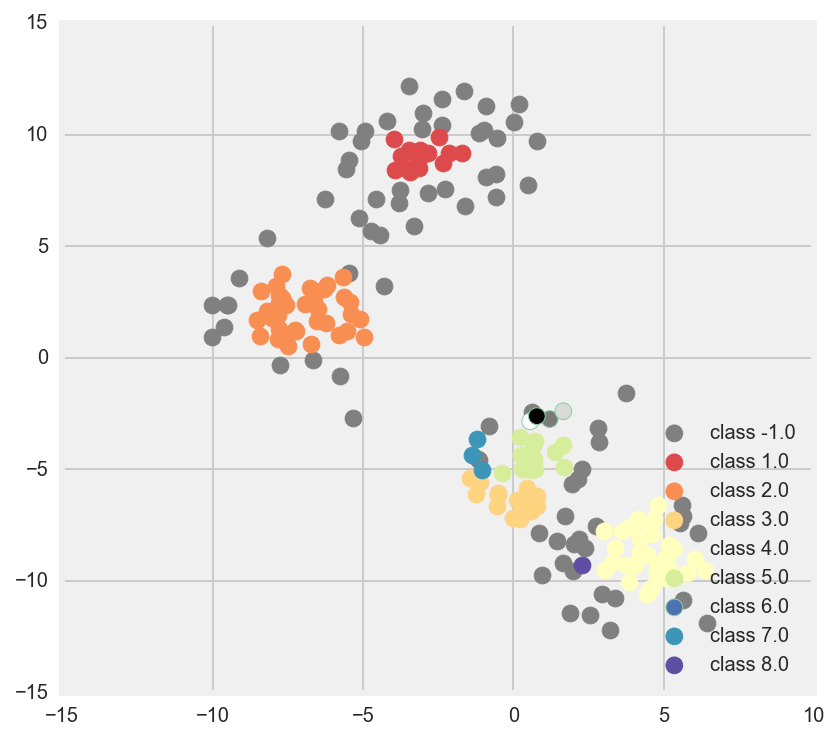

In [150]:
db = DBSCANKK(eps=.8)
db.fit(X)
print db.cluster_labels, np.unique(db.cluster_labels), len( np.unique(db.cluster_labels))
plot_db_clusters(X,db.cluster_labels)

---

## Plotting DBSCAN interactively

We can look at how the `eps` and `min_samples` parameters affect DBSCAN's decisions about assigning clusters. This is also a good opportunity to go over how to make interactive visualizations with ipython widgets.

### 1. Re-write the plotting function to accept cluster labels and color the points accordingly

In [144]:
def cluster_plotter(eps=1.0, min_samples=4):
    db =DBSCANKK(eps=eps, min_samples=min_samples)
    db.fit(X)
    plot_db_clusters(X, db.cluster_labels)
    
def cluster_interact():
    widgets.interact(cluster_plotter
                     , eps=widgets.FloatSlider(min=0.0
                                               , max=5.0
                                               , step=0.05
                                               , value= 1.0
                                               , continuous_update=False
                                              )
                    , min_samples=widgets.IntSlider(min=1
                                                  , max=25
                                                  , step=1
                                                  , value=5
                                                  , continuous_update= False)
                    )
                    



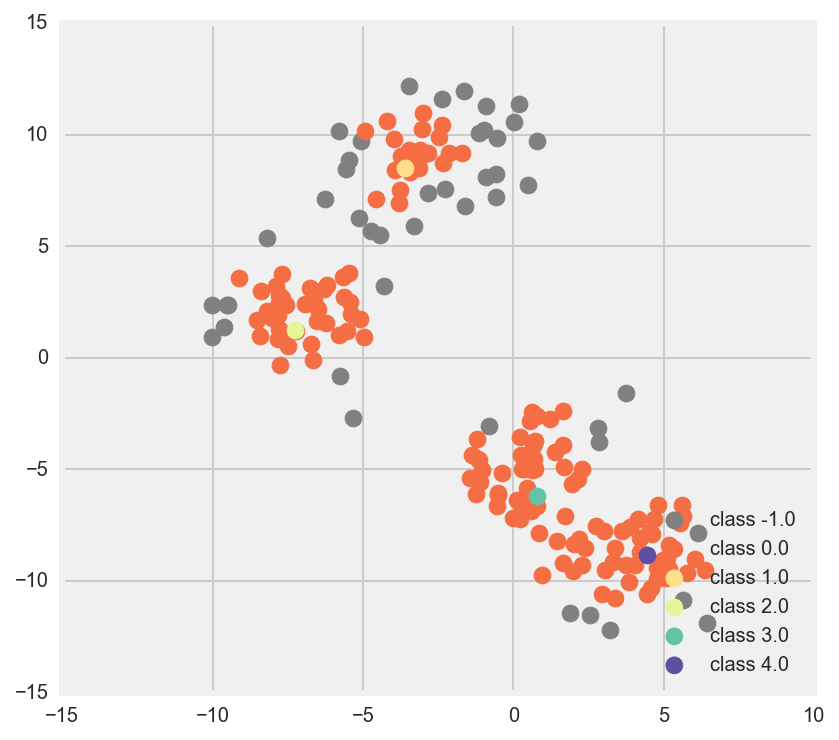

In [145]:
cluster_interact()

---

### 2. Write a function that accepts `eps` and `min_samples` as keyword arguments, fits DBSCAN, and calls the plotting function

Don't pass `X` in to the function. We will just use the "global" X defined in the jupyter notebook earlier.

---

### 3. Make the "interact" function that creates the ipython widget

Your interact function defines the sliders (or other inputs you want to be interactive) and then makes a call to `widgets.interact(function, *interactive objects)` where:

- "function" is the function that takes the values coming out of the interactive slider objects (we wrote it just before: it takes `eps` and `min_samples`
- The interactive objects in our case will be a `widgets.FloatSlider` for eps and a `widgets.IntSlider` for the min_samples.

For more information see this handy notebook:

https://github.com/ipython/ipywidgets/blob/master/docs/source/examples/Index.ipynb